# Predicting Housing Prices (Continued)


In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [4]:
training_data = pd.read_csv("ames_train_cleaned.csv")

# Part IV: More Feature Selection and Engineering

In this section, we identify two more features of the dataset that will increase our linear regression model's accuracy. Additionally, we will implement one-hot encoding so that we can include binary and categorical variables in our improved model.


First, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.

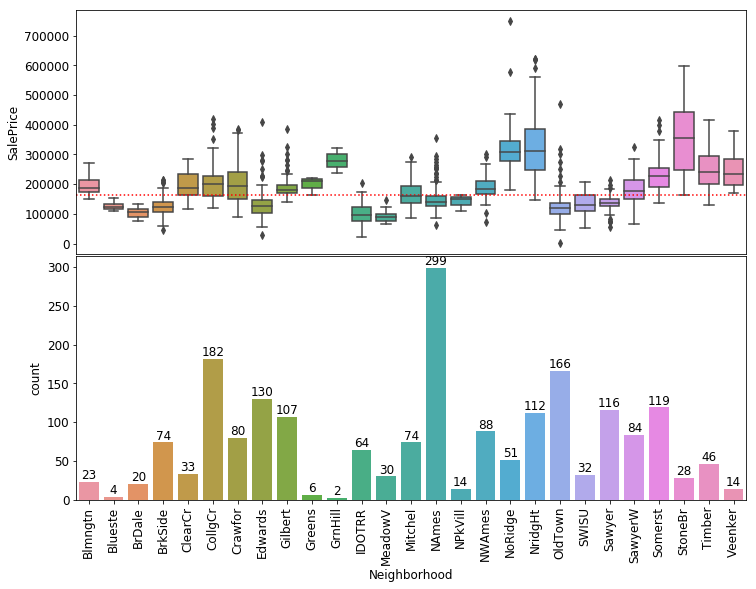

In [5]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

We can see that the sales price of the houses is not very uniformly distributed between different households. This makes sense because different areas might have different price indexes per unit of liviable area. 

Closer observation shows that the area with the most number of houses (NAmes) also has the sales price of most houses below the median. On the other hand we see that StoneBr and Nridgt have some of the highest sales prices in our data and not nearly as many houses available in that area. 

In realtion to our linear regression predictor, it is not unreasonable to see that the huge variance in the distribution of the prices of the houses along with thier non uniform distribution of the count of these houses could easily interfere in our linear regression model. 


One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods"; the other neighborhoods are not marked.


In [6]:
def find_rich_neighborhoods(data, n, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    a = training_data.groupby(['Neighborhood']).agg(metric)['SalePrice'].sort_values(ascending = False)[:n]
    neighborhoods = a.index.tolist()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']



We now have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`.  Write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.

In [8]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data['in_rich_neighborhood'] = data['Neighborhood'].isin(neighborhoods).astype(int)
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)


Let's see if our data set has any missing values.  

In [10]:
missing_counts = training_data.isnull().sum().sort_values(ascending= False)
missing_counts

Pool_QC            1991
Misc_Feature       1922
Alley              1865
Fence              1607
Fireplace_Qu        975
Lot_Frontage        352
Garage_Cond         114
Garage_Yr_Blt       114
Garage_Finish       114
Garage_Qual         114
Garage_Type         113
Bsmt_Exposure        57
BsmtFin_Type_2       56
Bsmt_Cond            56
Bsmt_Qual            56
BsmtFin_Type_1       56
Mas_Vnr_Type         18
Mas_Vnr_Area         18
BsmtFin_SF_1          1
BsmtFin_SF_2          1
Bsmt_Unf_SF           1
Total_Bsmt_SF         1
Electrical            1
Land_Slope            0
Exter_Cond            0
Exterior_2nd          0
Exter_Qual            0
MS_Zoning             0
Foundation            0
Neighborhood          0
                   ... 
Sale_Condition        0
Sale_Type             0
Yr_Sold               0
Mo_Sold               0
Misc_Val              0
Pool_Area             0
Screen_Porch          0
3Ssn_Porch            0
Enclosed_Porch        0
Open_Porch_SF         0
Wood_Deck_SF    

It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```



An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  

In [12]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    di = {'Ex': "Excellent", 'Gd': "Good",'TA': 'Average', 'Fa': 'Fair', 'Po': 'Poor'}
    data['Fireplace_Qu'].replace(di, inplace=True)
    data.fillna('No Fireplace', inplace=True)
    return data
    
training_data = fix_fireplace_qu(training_data)

In [14]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data.loc[:, 'Fireplace_Qu'] = data.loc[:, 'Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

In [15]:
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='fpq').head(10)

,fpq_Good,fpq_Average,fpq_Fair,fpq_Poor,fpq_No Fireplace
0,1,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0
6,0,0,0,0,1
7,0,1,0,0,0
8,0,0,0,0,1
9,1,0,0,0,0


# Part V: Improved Linear Models

In this section, we will create linear models that produce more accurate estimates of the housing prices in Ames.

## Adding Covariates to our Model

It's finally time to fit our updated linear regression model using the ordinary least squares estimator!

First, we will re-import the data and split `training_data` into a training and test set.

In [16]:
training_data = pd.read_csv("ames_train_cleaned.csv")

# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general
np.random.seed(1337)
training_data_len = len(training_data)
shuffled_indices = np.random.permutation(training_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:int(training_data_len * 0.8)]
test_indices = shuffled_indices[int(training_data_len * 0.8):]

# Create train and test` by indexing into `full_data` using 
# `train_indices` and `test_indices`
train = training_data.iloc[train_indices]
test = training_data.iloc[test_indices]

Next, we will implement a reusable pipeline that selects the required variables in our data and splits our covariates and response variable into a matrix and a vector, respectively.

In [17]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'fpq_Good',
                          'fpq_Average',
                          'fpq_Fair',
                          'fpq_Poor',
                          'fpq_No Fireplace',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

We then split our dataset into training and testing sets using our data cleaning pipeline.

In [18]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm(train)
X_test, y_test = process_data_gm(test)
train.head()

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
1504,2229,909475050,20,RL,No Fireplace,20693,Pave,No Fireplace,IR1,Bnk,...,No Fireplace,GdWo,No Fireplace,0,2,2007,WD,Normal,191400,2.0
1589,2349,527355060,60,RL,81,10530,Pave,No Fireplace,Reg,Lvl,...,No Fireplace,GdPrv,No Fireplace,0,7,2006,WD,Normal,182900,2.5
1617,2392,528138030,60,RL,85,11924,Pave,No Fireplace,IR1,Lvl,...,No Fireplace,No Fireplace,No Fireplace,0,7,2006,New,Partial,350900,4.0
835,1247,535302130,20,RL,102,9373,Pave,No Fireplace,IR1,Lvl,...,No Fireplace,No Fireplace,No Fireplace,0,5,2008,WD,Normal,145700,1.5
1704,2520,533253050,120,RL,36,3640,Pave,No Fireplace,IR1,Lvl,...,No Fireplace,No Fireplace,No Fireplace,0,9,2006,WD,Normal,182100,2.0


Finally, we initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept.

In [19]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True)

In [20]:
# Fit the model below
linear_model.fit(X_train, y_train)


# Compute the fitted and predicted values of SalePrice
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)

In [22]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [23]:
training_error = rmse(y_train, y_fitted)
test_error = rmse(y_test, y_predicted)

print("Training RMSE: {}\nTest RMSE: {}".format(training_error, test_error))

Training RMSE: 40491.84911146645
Test RMSE: 38754.860681844264


In the previous notebook the training and test error that I computed was as follows;

(46710.597505875856, 46146.64265682625)

Comparing this to the training and test error I computed in the new improved model we see that the RMSE has reduced by a significant margine from around the 46000 range to the 38000-40000 range. The reduction in RSME effectively means that this is a more accurate model. Hence, it is a better predictor. 

This gain in accuracy is significant. 


## Linear Model 

In [25]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

Let us select some interesting variables that can be inherently related to the Sales Price of Housing from the above list.

1) 'Lot_Area'

2) 'Overall_Qual'

3) 'Overall_Cond'

4) 'Year_Built' Age Feature

5) 'Garage_Cars'

In [26]:
training_data[['Lot_Area','Overall_Qual','Overall_Cond','Year_Built','Garage_Cars']].isna().sum()

Lot_Area        0
Overall_Qual    0
Overall_Cond    0
Year_Built      0
Garage_Cars     0
dtype: int64

In [27]:
final_model = lm.LinearRegression(fit_intercept=True) # No need to change this!

def process_data_fm(data):
    """Define Functions"""
    def select_columns(data, *columns):
        """Select only columns passed as arguments."""
        return data.loc[:, columns]
    
    def add_in_age(data):
        """Input: data (data frame): a data frame containing a 'Year_Built' column with values found in the codebook
        Output: data frame identical to the input with the addition of a numerical 'Age' column"""
        data['Age'] = 2019 - data['Year_Built']
        return data
    
    def find_rich_neighborhoods(data, n, metric=np.median):
        """Input: data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
        n (int): the number of top values desired
        metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
        Output:a list of the top n richest neighborhoods as measured by the metric function"""
        a = training_data.groupby(['Neighborhood']).agg(metric)['SalePrice'].sort_values(ascending = False)[:n]
        neighborhoods = a.index.tolist()
        return neighborhoods
    
    # Creating a Dict of rich neighborhoods
    rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
    
    def add_in_rich_neighborhood(data, neighborhoods):
        """Input:data (data frame): a data frame containing a 'Neighborhood' column with valuesfound in the codebook
        neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
        Output:data frame identical to the input with the addition of a binary in_rich_neighborhood column"""
        
        data['in_rich_neighborhood'] = data['Neighborhood'].isin(neighborhoods).astype(int)
        return data


    
    
    
    
    def fix_fireplace_qu(data):
        """Input:data (data frame): a data frame containing a Fireplace_Qu column.  Its values
        should be limited to those found in the codebook
        Output: data frame identical to the input except with a refactored Fireplace_Qu column"""
        
        di = {'Ex': "Excellent", 'Gd': "Good",'TA': 'Average', 'Fa': 'Fair', 'Po': 'Poor'}
        data['Fireplace_Qu'].replace(di, inplace=True)
        data.fillna('No Fireplace', inplace=True)
        return data
    
    def ohe_fireplace_qu(data):
        """
        One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
        """
        cats = [
            'Excellent',
            'Good',
            'Average',
            'Fair',
            'Poor',
            'No Fireplace'
            ]
        cat_type = CategoricalDtype(categories=cats)
        data.loc[:, 'Fireplace_Qu'] = data.loc[:, 'Fireplace_Qu'].astype(cat_type)
        data = pd.get_dummies(data,
                              prefix='fpq',
                              columns=['Fireplace_Qu'], 
                              drop_first=True)
        return data
    
    
    
    
    
    
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = add_in_age(data)
    
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'fpq_Good',
                          'fpq_Average',
                          'fpq_Fair',
                          'fpq_Poor',
                          'fpq_No Fireplace',
                          'Lot_Area',
                          'Overall_Qual',
                          'Age',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    
    #Final Checks
    X = X.apply(pd.to_numeric, errors='coerce')
    X['Garage_Area'].fillna(0,inplace=True)
    


    
    return X, y

The below code was just used for testing the required code. According to the results both the RSME were below 35K.

In [29]:
training_data = pd.read_csv('ames_train_cleaned.csv')
test_data = pd.read_csv('ames_test_cleaned.csv')

X_train, y_train = process_data_fm(training_data)
X_test, y_test = process_data_fm(test_data)

final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)

In [30]:
training_rmse

33405.5274805969

In [31]:
test_rmse

33889.190497161144

## EDA for Feature Selection


/srv/conda/envs/data100/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Comparison of Casual vs Registered Riders on Working and non Working Days with Overplotting')

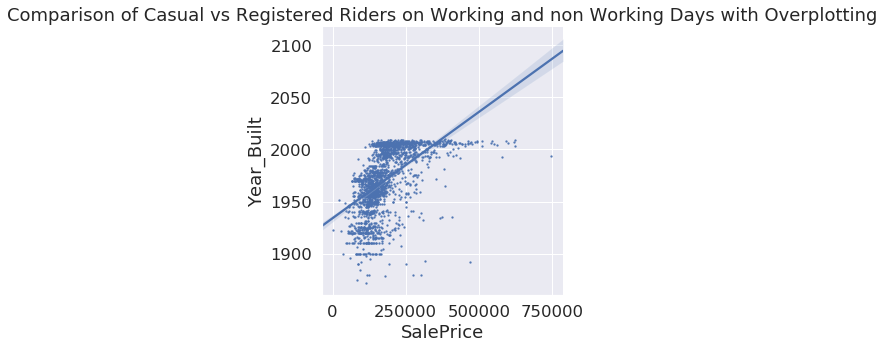

In [32]:
# Code for visualization goes here
sns.set(font_scale = 1.5)
sns.lmplot(x = 'SalePrice', y = 'Year_Built', data = training_data, scatter_kws={"s":1.90})
plt.title('Comparison of Casual vs Registered Riders on Working and non Working Days with Overplotting')

We know that inherently how old a house is definately a factor in how expensive it might be. Newer houses might be more expensive. However from the above plot we see that there is definately a linear relationship between the two. However there also seems to be a bit too much noise. 

After creating the plot I added this feature in the form of numeric age, calculated by subtracting the current year from the year it was built in. This significantly helped the model.

Other plots not displayed above also showed the existence of multicolinearity between garage area and number of garage cars. This is why I choose only one feature between these two. 